In [27]:
from IPython.display import display, Math
import sympy as sp 


def afficheSimpy(expr) : 
    display(Math(sp.latex(expr)))
    return 

def rendreJoli(expr, u, x, t, dx, dt, ORDER_SERIES):
    """
    Retourne un latex isolant le puissances des deltaX et deltaT à l'affichage.
    """
    orders = range(0, ORDER_SERIES + 1) # Liste des ordres de dérivés temporelles que l'expression est suceptible de porter 
    dxs = [dx**n for n in orders] # Liste des puissances de deltaX 
    dts = [dt**n for n in orders] # Liste des puissances de deltaT 
    expr = expr.expand() # développe l'expression
    collected_dx = sp.collect(expr, dxs, evaluate=False) # cére un dictionnaire avec en clé les puissances de deltaX et en valeur les coeffs associés
    
    latex_lines = [] # liste des termes
    for dx_term, dx_expr in collected_dx.items(): # On itère sur les puissances de detaX (dx_term) et on accès au coefficient associés (dx_expr)
        collected_dt = sp.collect(dx_expr, dts, evaluate=False) # Crée un dictionnaire avec en clée les puissances de deltaT et en valeur les coeffs 
        for dt_term, coef in collected_dt.items():
            factor_parts = []
            if dt_term != 1:
                factor_parts.append(sp.latex(dt_term))
            if dx_term != 1:
                factor_parts.append(sp.latex(dx_term))
            factor_str = " ".join(factor_parts)
            
            if factor_str:
                latex_lines.append(f"{factor_str} \\left({sp.latex(coef)}\\right)")
            else:
                latex_lines.append(sp.latex(coef))
    
    return " + ".join(latex_lines)


def relation_fermeture(f:sp.Function,x:sp.Symbol,t:sp.Symbol,order:int,D:float) : 
    """
    Calcule la relation de fermeture permettant d'appliquer la procédure de Cauchy-Kovaleskaya pour l'équation de la chaleur
    f       : fonction à variables spatio-temporelle.
    x       : variable d'espace
    t       : variable temporelle
    order   : ordre de la dérivée temporelle à évaluer
    D       : coefficient de diffusion scalaire
    """
    return D**order * sp.diff(f(x,t),x,2*order)

def developpement_taylor_spatial(f:sp.Function,h:sp.Symbol,order:int,x:sp.Symbol,t:sp.Symbol):
    """
    Calcule le développement de tailor autour du point générique x au poit x+h. 
    f       : fonction à estimer.
    h       : écart par rapport à x.
    order   : ordre du DL. 
    x       : variable d'espace
    t       : varible en temps
    """
    return sum([
        h**k * sp.Rational(1,sp.factorial(k)) * sp.diff(f(x, t), x, k) 
        for k in range(order + 1)
    ]) 

def developpement_taylor_temps(f:sp.Function, h:sp.Symbol,order:int,x:sp.Symbol,t:sp.Symbol):
    """
    Calcule le développement de tailor autour du point générique t au poit t+h. 
    f       : fonction à estimer.
    h       : écart par rapport à t.
    order   : ordre du DL. 
    x       : variable d'espace
    t       : variable temporelle
    """
    return sum([
        h**k * sp.Rational(1,sp.factorial(k)) * sp.diff(f(x, t), t, k) 
        for k in range(order + 1)
    ]) 

def fourrier_voisin(f:sp.Function,h:sp.Symbol,xi:sp.Symbol,t:sp.Symbol) : 
    return f(xi,t) * sp.exp(-sp.I*xi*h)

DEBUG = 0
ORDER_SERIES = 4 # ordre des développements limités. 
DT_FROM_CFL = 0 # choisir si on défini dt à partir de la CFL ou si l'on défini la CFL à partir de dt. 
CAUCHY_KOVALESKAYA = 1
D = sp.Symbol("D", real=True) #Coefficient de diffusion
x, t = sp.symbols("x t", real=True)#Varaiables espace-temps
dx = sp.Symbol(r"\Delta x", real=True)#Pas de discrétisation spatial (niveau fin et grille uniforme)
u = sp.Function("u")#Fonction "régulière" vérifiant le schéma

u_fourrier =  sp.Function(r"\hat{u}")
xi = sp.Symbol(r"\xi",real = True)
if DT_FROM_CFL :
    CFL_DIFF = sp.Symbol(r"\lambda", real=True)
    dt = dx**2 * CFL_DIFF / D
else : 
    dt = sp.Symbol(r"\Delta t", real=True)
    CFL_DIFF = D * dt / dx**2
CFL_DIFF = D * dt / dx**2 
s_hat = sp.Symbol('$\hat s$', positive=True)
deltal = sp.Symbol(u'\\Delta l', positive=True)
fourrier_voisin(u_fourrier,-dx,xi,t)

\hat{u}(\xi, t)*exp(I*\Delta x*\xi)

In [28]:

def ordre_total_derivée(expr:sp.Expr):
    """
    Renvoie l'ordre de dérivation de l'expression entrée.
    Sert dans la procédure de Cauchy-Kovaleskaya.
    """
    return sum(o for _, o in expr.variable_count) if isinstance(expr, sp.Derivative) else 0

def apply_cauchy_kovaleskaya(expr,u,x,t,D,max_order):
    """
    applique Cauchy-Kovaleskaya à l'argument expr utilisant la relation de fermuture : dtu = D * dxxu
    expr        : expression à laquelle appliquer la procédure.
    u           : fonction
    x           : variable spatiale
    t           : variable temporelle
    D           : coefficient de diffusion
    max_order   : ordre de développement maximal
    """
    expr.expand() # Développe l'expression
    coeffs_dtn = sp.collect( # Crée un dictionnaire avec en clée les dérivées temporelle aux différents ordres qui apparaissent dans expr et en valeur les coefficients associés 
        expr ,
        [sp.diff(u(x, t), t,localOrder) for localOrder in range(2,max_order+1) ], # L'objectif est de remplacer les dérivées temporelles d'ordre 2 et plus.
        evaluate=False # Renvoie un dictionnaire et non seulement 
        )
    for (key,value) in coeffs_dtn.items(): # On itère sur les dérivées temporelles (key) en ayant accès a leurs coeffcients (value)
        ordre  = ordre_total_derivée(key)  # On récupère l'ordre de la dérivée temporelle sur laquelle on travaile
        if ordre == 0 : continue
        terme_temporel = key * value # On reconstruit le terme associé à la dérivée tempoelle
        terme_spatial = relation_fermeture(u,x,t,ordre , D) * value # On construit le terme associé faisant intervenir une dérivée spatiale à la place (c'est ici que l'on a besoin de l'ordre de la dérivée temporelle)
        expr = expr - terme_temporel + terme_spatial # On remplace le terme faisant intervenir la dérivée temporelle et on le remplace par celui mettant en jeu la dérivée spatiale
    return expr

def initP(stencil=1) :
    if stencil==1 : 
        P = sp.zeros(4,4)
        P[0,0] = sp.Rational(1,8)
        P[1,0] = sp.Rational(-1,8)
        P[2,1] = sp.Rational(1,8)
        P[3,1] = sp.Rational(-1,8)
        P[0,2] = sp.Rational(-1,8)
        P[1,2] = sp.Rational(1,8)
        P[2,3] = sp.Rational(-1,8)
        P[3,3] = sp.Rational(1,8)
        P[0,1] = 1
        P[1,1] = 1
        P[2,2] = 1
        P[3,2] = 1
        return P 
    else : raise NotImplementedError(f"not implemented s={stencil}")

def computeFlux(u,u_fourrier,x,t,dl,dx,cfl,ORDER_SERIES,stencil=1):
    dx_currentLevel = (2**(dl)) * dx # Calcul du deltaX courrant
    cfl_effective = cfl*(2**(-dl))
    cfl_effective_without_recons = cfl*(2**(-2*dl))
    Pdl = initP(stencil)**dl # Calcul de la matrice de passage au travers de deltaL couches
    coeffs = sp.Matrix([[
        sp.Rational(-1,2)*cfl_effective,
        +sp.Rational(3,2)*cfl_effective-1,
        -sp.Rational(3,2)*cfl_effective+1,
        sp.Rational(1,2)*cfl_effective,
        ]])
    
    coeffs_1 = sp.Matrix([[0,-1,1,0,]])
    coeffs_2 = sp.Matrix([[sp.Rational(-1,2),sp.Rational(+3,2),sp.Rational(-3,2),sp.Rational(1,2),]]) #* sp.Rational(1,2)
    
    Us_minusFlux_currentLevel = sp.Matrix([developpement_taylor_spatial(u,dx_currentLevel*delta,ORDER_SERIES,x,t) for delta in range(-2,2)])
    Us_plusFlux_currentLevel = sp.Matrix([developpement_taylor_spatial(u,dx_currentLevel*delta,ORDER_SERIES,x,t)  for delta in range(-1,3)])

    Us_minusFlux_currentLevel_fourrier = sp.Matrix([fourrier_voisin(u_fourrier,dx_currentLevel*delta,xi,t) for delta in range(-2,2)])
    Us_plusFlux_currentLevel_fourrier = sp.Matrix([fourrier_voisin(u_fourrier,dx_currentLevel*delta,xi,t)  for delta in range(-1,3)])
    # afficheSimpy(Us_plusFlux_currentLevel_fourrier)
    # afficheSimpy(Us_minusFlux_currentLevel_fourrier)
    # minusFlux = (coeffs * Pdl * Us_minusFlux_currentLevel)[0,0]
    # plusFlux  = (coeffs * Pdl *  Us_plusFlux_currentLevel)[0,0]
    # flux_variation_RK2_v1 = (cfl_effective * (plusFlux-minusFlux)).expand()
    minusFlux = ((cfl_effective*coeffs_1+cfl_effective**2*coeffs_2)*(Pdl * Us_minusFlux_currentLevel))[0,0]
    plusFlux  = ((cfl_effective*coeffs_1+cfl_effective**2*coeffs_2)*(Pdl *  Us_plusFlux_currentLevel))[0,0]

    minusFlux_Fourrier = ((cfl_effective*coeffs_1+cfl_effective**2*coeffs_2)*(Pdl * Us_minusFlux_currentLevel_fourrier))[0,0]
    plusFlux_Fourrier  = ((cfl_effective*coeffs_1+cfl_effective**2*coeffs_2)*(Pdl * Us_plusFlux_currentLevel_fourrier))[0,0]

    minusFlux_Fourrier_without_recons = ((cfl_effective_without_recons*coeffs_1+cfl_effective_without_recons**2*coeffs_2)*(Us_minusFlux_currentLevel_fourrier))[0,0]
    plusFlux_Fourrier_without_recons  = ((cfl_effective_without_recons*coeffs_1+cfl_effective_without_recons**2*coeffs_2)*(Us_plusFlux_currentLevel_fourrier))[0,0]

    # afficheSimpy(minusFlux_Fourrier.expand())
    # afficheSimpy(plusFlux_Fourrier.expand())
    flux_variation_RK2 = (plusFlux-minusFlux).expand()
    flux_variation_RK2_fourrier = (plusFlux_Fourrier - minusFlux_Fourrier).expand()
    coefficient_amplification_RK2 = 1 + (flux_variation_RK2_fourrier / u_fourrier(xi,t))

    flux_variation_RK2_fourrier_without_recons = (plusFlux_Fourrier_without_recons - minusFlux_Fourrier_without_recons).expand()
    coefficient_amplification_RK2_without_recons  = 1 + (flux_variation_RK2_fourrier_without_recons / u_fourrier(xi,t))
    # afficheSimpy(coefficient_amplification_RK2.expand().collect(cfl))
    coeffs_RK1 = sp.Matrix([[0,-1,1,0,]])
    minusFlux_RK1 = (coeffs_RK1 * Pdl * Us_minusFlux_currentLevel)[0,0]
    plusFlux_RK1 = (coeffs_RK1 * Pdl * Us_plusFlux_currentLevel)[0,0]
    flux_variation_RK1 = cfl_effective * (plusFlux_RK1-minusFlux_RK1)

    coeffs_Christian = sp.Matrix([[
        sp.Rational(-1,2)*(cfl-sp.Rational(1,6)) ,
        sp.Rational(3,2)*(cfl-sp.Rational(1,6))-1,
        1-sp.Rational(3,2)*(cfl-sp.Rational(1,6)),
        sp.Rational(1,2)*(cfl-sp.Rational(1,6)) ,
                        ]])
    minusFlux_Christian = (coeffs_Christian * Pdl * Us_minusFlux_currentLevel)[0,0]
    plusFlux_Christian = (coeffs_Christian * Pdl * Us_plusFlux_currentLevel)[0,0]
    flux_variation_Christian = cfl_effective * (plusFlux_Christian-minusFlux_Christian)

    return  flux_variation_RK2,flux_variation_RK1,flux_variation_Christian,coefficient_amplification_RK2,coefficient_amplification_RK2_without_recons


computeFlux(u,u_fourrier,x,t,deltal,dx,CFL_DIFF,ORDER_SERIES,stencil=1)


(-2**(2*\Delta l)*D*\Delta l*\Delta t*\Delta x**2*Derivative(u(x, t), (x, 4))/4 + 2**(2*\Delta l)*D*\Delta t*\Delta x**2*Derivative(u(x, t), (x, 4))/12 + 2**\Delta l*D**2*\Delta t**2*Derivative(u(x, t), (x, 4))/2 + D*\Delta t*Derivative(u(x, t), (x, 2)),
 D*\Delta t*(2**(1 - \Delta l)*\Delta l*(2**(4*\Delta l)*\Delta x**4*Derivative(u(x, t), (x, 4))/24 - 2**(3*\Delta l)*\Delta x**3*Derivative(u(x, t), (x, 3))/6 + 2**(2*\Delta l)*\Delta x**2*Derivative(u(x, t), (x, 2))/2 - 2**\Delta l*\Delta x*Derivative(u(x, t), x) + u(x, t))/8 + 2**(1 - \Delta l)*\Delta l*(2**(4*\Delta l)*\Delta x**4*Derivative(u(x, t), (x, 4))/24 + 2**(3*\Delta l)*\Delta x**3*Derivative(u(x, t), (x, 3))/6 + 2**(2*\Delta l)*\Delta x**2*Derivative(u(x, t), (x, 2))/2 + 2**\Delta l*\Delta x*Derivative(u(x, t), x) + u(x, t))/8 - 2**(1 - \Delta l)*\Delta l*(2*2**(4*\Delta l)*\Delta x**4*Derivative(u(x, t), (x, 4))/3 - 4*2**(3*\Delta l)*\Delta x**3*Derivative(u(x, t), (x, 3))/3 + 2*2**(2*\Delta l)*\Delta x**2*Derivative(u(x

In [29]:

def computeEqModif(u,u_fourrier,x,t,dl,dx,dt,D,cfl,ORDER_SERIES,CAUCHY_KOVALESKAYA=True,stencil=1,DEBUG=0) : 
    flux_total_RK2,flux_total_RK1,flux_total_Christian,coeff_amplification_RK2,coeff_amplification_RK2_without_recons = computeFlux(u,u_fourrier,x,t,dl,dx,cfl,ORDER_SERIES,stencil=1) 
    rhs = (1/dt*flux_total_RK2).expand() #RK2
    rhs_RK1 = (1/dt*flux_total_RK1).expand() #RK1
    rhs_Christian = (1/dt*flux_total_Christian).expand() #RK2 - Modifiée Christian 
    lhs = (1/dt * (developpement_taylor_temps(u,dt,ORDER_SERIES,x,t) - u(x,t))).expand() # Approximation de la dérivée temporelle : (u^n+1 - u^n)/dt
    rhs = rhs - (lhs - sp.diff(u(x,t),t,1)) #RK2
    rhs_RK1 = rhs_RK1-(lhs - sp.diff(u(x,t),t,1)) #RK1
    rhs_Christian = rhs_Christian-(lhs - sp.diff(u(x,t),t,1)) #RK2 - Modifiée Christian 
    lhs = sp.diff(u(x,t),t,1)
    if CAUCHY_KOVALESKAYA : 
        rhs=apply_cauchy_kovaleskaya(rhs,u,x,t,D,ORDER_SERIES) #RK2
        rhs_RK1=apply_cauchy_kovaleskaya(rhs_RK1,u,x,t,D,ORDER_SERIES)  #RK1
        rhs_Christian=apply_cauchy_kovaleskaya(rhs_Christian,u,x,t,D,ORDER_SERIES)  #RK2 - Modifiée Christian 
    tex =sp.latex(lhs) + "=" + (rendreJoli(rhs,u,x,t,dx,dt,4)) #RK2
    
    tex_RK1 =sp.latex(lhs) + "=" + sp.latex(rhs_RK1) #RK2
    tex_Christian = sp.latex(lhs) + "=" + sp.latex(rhs_Christian) #RK2 - Modifiée Christian 
    return {"RK2":(lhs,rhs,tex),"RK1":(lhs,rhs_RK1,tex_RK1),"Christian" : (lhs,rhs_Christian,tex_Christian)}  , coeff_amplification_RK2,coeff_amplification_RK2_without_recons# Dictionnaire



DEBUG = 0
ORDER_SERIES = 4 # ordre des développements limités. 
DT_FROM_CFL = 1 # choisir si on défini dt à partir de la CFL ou si l'on défini la CFL à partir de dt. 
CAUCHY_KOVALESKAYA = 1
D = sp.Symbol("D", real=True) #Coefficient de diffusion
x, t = sp.symbols("x t", real=True)#Varaiables espace-temps
dx = sp.Symbol(r"\Delta x", real=True)#Pas de discrétisation spatial (niveau fin et grille uniforme)
u = sp.Function("u")#Fonction "régulière" vérifiant le schéma

u_fourrier =  sp.Function(r"\hat{u}")
xi = sp.Symbol(r"\xi",real = True)
if DT_FROM_CFL :
    CFL_DIFF = sp.Symbol(r"\lambda", real=True)
    dt = dx**2 * CFL_DIFF / D
else : 
    dt = sp.Symbol(r"\Delta t", real=True)
    CFL_DIFF = D * dt / dx**2
CFL_DIFF = D * dt / dx**2 
s_hat = sp.Symbol('$\hat s$', positive=True)
deltal = sp.Symbol(u'\\Delta l', positive=True)

u_xplus1 = developpement_taylor_spatial(u,+dx,ORDER_SERIES,x,t) # développement de Taylor en espace en x+dx
u_xplus2 = developpement_taylor_spatial(u,+2*dx,ORDER_SERIES,x,t) # développement de Taylor en espace en x+2dx
u_xmoins1 = developpement_taylor_spatial(u,-dx,ORDER_SERIES,x,t) # développement de Taylor en espace en x-dx
u_xmoins2 = developpement_taylor_spatial(u,-2*dx,ORDER_SERIES,x,t) # développement de Taylor en espace en x-2dx
reste_serie_en_temps =((developpement_taylor_temps(u,dt,ORDER_SERIES,x,t) - u(x,t))/dt - sp.diff(u(x,t),t)).expand() # Erreur résiduelle lorsque l'on approxime du/dt = (u^t+1 - u^t)/dt
derivee_temporelle = sp.diff(u(x, t), t) # dérivée temporelle d'ordre 1


# Méthode des lignes RK1
print("Eq modifée temps-espace RKE1")
flux_total_sans_AMR_RK1 = (CFL_DIFF * 
                        (u_xplus1 - 2*u(x,t) + u_xmoins1)).expand()
u_t_RK1 = - reste_serie_en_temps + 1/dt*flux_total_sans_AMR_RK1
u_t_RK1 = u_t_RK1.expand()
u_t_RK1 = apply_cauchy_kovaleskaya(u_t_RK1,u,x,t,D,ORDER_SERIES)
eq_sans_AMR_RK1 = f"{sp.latex(derivee_temporelle)} = {sp.latex(u_t_RK1)}"
display(Math(eq_sans_AMR_RK1))

# Méthode des lignes RK2
print("Eq modifée temps-espace RKE2")
flux_total_sans_AMR = CFL_DIFF*(
                    (u_xplus1 - 2*u(x,t) + u_xmoins1) 
                       +sp.Rational(1,2) * CFL_DIFF*(u_xplus2 - 4*u_xplus1 + 6*u(x,t) - 4*u_xmoins1 + u_xmoins2)
                    ).expand()
var_flux_RK2_sans_AMR_fourrier =((1/ u_fourrier(xi,t))*(CFL_DIFF * (
                                    + fourrier_voisin(u_fourrier , dx ,xi,t)
                                    - 2*u_fourrier(xi,t)
                                    + fourrier_voisin(u_fourrier,-dx,xi,t)
                                    )+ CFL_DIFF**2 * (
                                    + sp.Rational(1,2) * fourrier_voisin(u_fourrier , 2*dx ,xi,t)
                                    -2 * fourrier_voisin(u_fourrier , dx ,xi,t)
                                    +3 * u_fourrier(xi,t)
                                    -2 * fourrier_voisin(u_fourrier , -dx ,xi,t)
                                    + sp.Rational(1,2) * fourrier_voisin(u_fourrier , -2*dx ,xi,t)
                        ))).expand()
coeff_ampli_sans_AMR = 1 + var_flux_RK2_sans_AMR_fourrier
u_t = - reste_serie_en_temps +(1/dt) * flux_total_sans_AMR # équation équivalente brute. 
u_t = u_t.expand()
u_t = apply_cauchy_kovaleskaya(u_t,u,x,t,D,ORDER_SERIES)
second_membre = rendreJoli(u_t,u,x,t,dx,dt,ORDER_SERIES)
eq_sans_AMR_Latex = f"{sp.latex(derivee_temporelle)} = {sp.latex(u_t)}"
display(Math(eq_sans_AMR_Latex))

### Christian 
print("Eq modifée temps-espace Version Christian")
flux_total_sans_AMR_Chr = CFL_DIFF*((u_xplus1 - 2*u(x,t) + u_xmoins1)
                        +sp.Rational(1,2)*(CFL_DIFF - sp.Rational(1,6))* (u_xplus2 - 4*u_xplus1 + 6*u(x,t) - 4*u_xmoins1 + u_xmoins2)).expand()
u_t_Chr = - reste_serie_en_temps + 1/dt*flux_total_sans_AMR_Chr
u_t_Chr = u_t_Chr.expand()
u_t_Chr = apply_cauchy_kovaleskaya(u_t_Chr,u,x,t,D,ORDER_SERIES)
eq_sans_AMR_Chr = f"{sp.latex(derivee_temporelle)} = {sp.latex(u_t_Chr)}"
display(Math(eq_sans_AMR_Chr))



dictionnary,coefficient_amplification,coeff_amplification_RK2_without_recons             = computeEqModif(u,u_fourrier,x,t,deltal,dx,dt,D,CFL_DIFF,ORDER_SERIES,CAUCHY_KOVALESKAYA=CAUCHY_KOVALESKAYA,stencil=1,DEBUG=DEBUG)
# print("--------------------------------------  EQUA. MODIFIEES [RK1] --------------------------------------")
# _,_,texRK1    = dictionnary["RK1"]
# print("\n       *   SANS Multi-Résolution   ❌\n")
# display(Math(eq_sans_AMR_Latex))
# print("\n       *  AVEC Multi-Résolution    ✅")
# display(Math(texRK1))

print("--------------------------------------  EQUA. MODIFIEES [RK2] --------------------------------------")
_,_,texRK2             = dictionnary["RK2"]
print("\n       *   SANS Multi-Résolution   ❌\n")
print(eq_sans_AMR_Latex)
display(Math(eq_sans_AMR_Latex))
print("\n       *  AVEC Multi-Résolution   ✅")
display(Math(texRK2))

# print("--------------------------------------  EQUA. MODIFIEES [RK2 - Christian] --------------------------------------")
# _,_,texChristian             = dictionnary["Christian"]
# print("\n       *   SANS Multi-Résolution   ❌\n")
# display(Math(eq_sans_AMR_Latex))
# print("\n       *  AVEC Multi-Résolution   ✅")
# display(Math(texChristian))


Eq modifée temps-espace RKE1


<IPython.core.display.Math object>

Eq modifée temps-espace RKE2


<IPython.core.display.Math object>

Eq modifée temps-espace Version Christian


<IPython.core.display.Math object>

--------------------------------------  EQUA. MODIFIEES [RK2] --------------------------------------

       *   SANS Multi-Résolution   ❌

\frac{\partial}{\partial t} u{\left(x,t \right)} = - \frac{D \Delta x^{6} \lambda^{3} \frac{\partial^{8}}{\partial x^{8}} u{\left(x,t \right)}}{24} - \frac{D \Delta x^{4} \lambda^{2} \frac{\partial^{6}}{\partial x^{6}} u{\left(x,t \right)}}{6} + \frac{D \Delta x^{2} \frac{\partial^{4}}{\partial x^{4}} u{\left(x,t \right)}}{12} + D \frac{\partial^{2}}{\partial x^{2}} u{\left(x,t \right)}


<IPython.core.display.Math object>


       *  AVEC Multi-Résolution   ✅


<IPython.core.display.Math object>

In [30]:
import numpy as np
import matplotlib.pyplot as plt 
coefficient_amplification = coefficient_amplification.expand()
print(coefficient_amplification)
afficheSimpy(coefficient_amplification)
print("Sans AMR")
coeff_ampli_sans_AMR=coeff_ampli_sans_AMR.rewrite(sp.cos).collect(CFL_DIFF)
print(coeff_ampli_sans_AMR)
afficheSimpy(coeff_ampli_sans_AMR)


1 - \Delta l*\lambda*exp(2*2**\Delta l*I*\Delta x*\xi)/(4*2**(2*\Delta l)) + \Delta l*\lambda*exp(2**\Delta l*I*\Delta x*\xi)/2**(2*\Delta l) - 3*\Delta l*\lambda/(2*2**(2*\Delta l)) + \Delta l*\lambda*exp(-2**\Delta l*I*\Delta x*\xi)/2**(2*\Delta l) - \Delta l*\lambda*exp(-2*2**\Delta l*I*\Delta x*\xi)/(4*2**(2*\Delta l)) + \lambda*exp(2**\Delta l*I*\Delta x*\xi)/2**(2*\Delta l) - 2*\lambda/2**(2*\Delta l) + \lambda*exp(-2**\Delta l*I*\Delta x*\xi)/2**(2*\Delta l) + \lambda**2*exp(2*2**\Delta l*I*\Delta x*\xi)/(2*2**(3*\Delta l)) - 2*\lambda**2*exp(2**\Delta l*I*\Delta x*\xi)/2**(3*\Delta l) + 3*\lambda**2/2**(3*\Delta l) - 2*\lambda**2*exp(-2**\Delta l*I*\Delta x*\xi)/2**(3*\Delta l) + \lambda**2*exp(-2*2**\Delta l*I*\Delta x*\xi)/(2*2**(3*\Delta l))


<IPython.core.display.Math object>

Sans AMR
\lambda**2*(-4*cos(\Delta x*\xi) + cos(2*\Delta x*\xi) + 3) + \lambda*(2*cos(\Delta x*\xi) - 2) + 1


<IPython.core.display.Math object>

In [31]:

user_delta_l = 2
user_cfl = 0.6
L = 1
LEVEL = 10
N_POINTS = 2**LEVEL
user_dx = L/N_POINTS

afficheSimpy(sp.simplify(sp.expand_complex(coeff_amplification_RK2_without_recons.rewrite(sp.cos))))

local_coeff_ampli_sans_AMR = coeff_ampli_sans_AMR.subs([(CFL_DIFF,user_cfl),(dx,user_dx)])
local_coefficient_amplification = coefficient_amplification.subs([(deltal , user_delta_l) , (CFL_DIFF , user_cfl) , (dx , user_dx)]).simplify()

# afficheSimpy(local_coefficient_amplification)
print("Sans AMR")
afficheSimpy(sp.simplify(sp.expand_complex(coeff_ampli_sans_AMR.rewrite(sp.cos))))
print("Avec AMR - Évaluation niveau courrant")
afficheSimpy(sp.simplify(sp.expand_complex(coeff_amplification_RK2_without_recons.rewrite(sp.cos).simplify())))
print("Avec AMR - Évaluation niveau fin")
afficheSimpy(sp.simplify(sp.expand_complex(coefficient_amplification.rewrite(sp.cos).simplify().collect(sp.Rational(1,2)))))


<IPython.core.display.Math object>

Sans AMR


<IPython.core.display.Math object>

Avec AMR - Évaluation niveau courrant


<IPython.core.display.Math object>

Avec AMR - Évaluation niveau fin


<IPython.core.display.Math object>

[0.00000000e+00 3.14466361e+00 6.28932723e+00 ... 3.21070155e+03
 3.21384621e+03 3.21699088e+03]


/var/folders/rg/g39v1pbj2wb5lg57tl9k_ws80000gq/T/ipykernel_69441/433041722.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("magma", len(cfl_list))


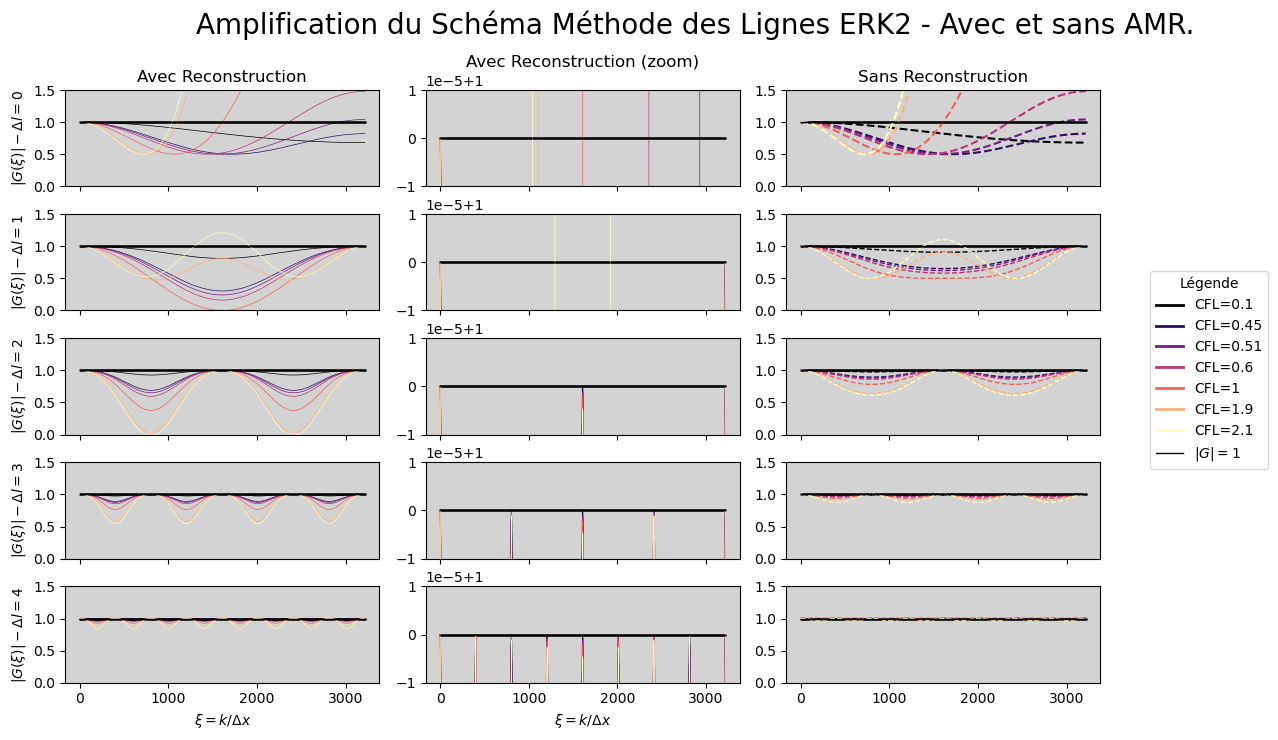

In [32]:

# Création de la fonction numérique numpy-compatible
G = sp.lambdify(xi, local_coefficient_amplification, "numpy")
G_simple = sp.lambdify(xi , local_coeff_ampli_sans_AMR,"numpy" )

xis = np.linspace(0,np.pi/user_dx,N_POINTS)
print(xis)
# Valeurs numériques
import matplotlib.cm as cm
from matplotlib.lines import Line2D

# --- paramètres ---
cfl_list = [0.1, 0.45, 0.51, 0.6,1,1.9,2.1]
dl_list  = [1, 2, 3, 4]
cmap = cm.get_cmap("magma", len(cfl_list))

# Abscisses (si non défini plus haut)
try:
    xis
except NameError:
    xis = np.linspace(0.0, np.pi, 2000)

# --- figure : (nombre_dl + 1) x 2 ---
nrows = len(dl_list) + 1
ncols = 3
fig_h = 1.5 * nrows
fig, axs = plt.subplots(nrows, ncols, figsize=(14, fig_h), sharex=True, sharey=False)
fig.suptitle(rf"Amplification du Schéma Méthode des Lignes ERK2 - Avec et sans AMR.",fontsize = 20)

# Fond lightgray
fig.patch.set_facecolor("white")
for r in range(nrows):
    for c in range(ncols):
        axs[r, c].set_facecolor("lightgray")

# ----------------- Ligne 0 : Sans AMR -----------------
for i, cfl in enumerate(cfl_list):
    color = cmap(i)
    local_coeff_ampli_sans_AMR = coeff_ampli_sans_AMR.subs([(CFL_DIFF, cfl), (dx, user_dx)])
    G_simple = sp.lambdify(xi, local_coeff_ampli_sans_AMR, "numpy")
    amp_simple = G_simple(xis)
    local_coeff_amplification_RK2_without_recons = coeff_amplification_RK2_without_recons.subs([(deltal , 0) , (CFL_DIFF , cfl) , (dx , user_dx)]).simplify()
    G_without_recons = sp.lambdify(xi,local_coeff_amplification_RK2_without_recons,'numpy')
    amp_without_recons_simple =G_without_recons(xis)
    # Col 0 : vue générale
    ax = axs[0, 0]
    ax.plot(xis, np.abs(amp_simple), color=color, linestyle='-', linewidth=.5)
    ax.plot(xis, np.ones_like(xis), color='black', linewidth=1)  # |G|=1
    ax.set_ylabel(fr"$|G(\xi)| - \Delta l = 0$")
    ax.set_ylim(0,1.5)

    # Col 1 : zoom autour de 1
    ax = axs[0, 1]
    ax.set_ylim([1 - 1e-5, 1 + 1e-5])
    ax.plot(xis, np.abs(amp_simple), color=color, linestyle='-', linewidth=.5)
    ax.plot(xis, np.ones_like(xis), color='black', linewidth=1)  # |G|=1
    ax=axs[0,2]
    axs[0,2].set_ylim([0,1.5])
    ax.plot(xis,np.abs(amp_without_recons_simple),color=color,linestyle = "dashed")
    ax.plot(xis, np.ones_like(xis), color='black', linewidth=1)  

# ----------------- Lignes 1.. : Avec AMR (Δl = 1..4) -----------------
for r, user_delta_l in enumerate(dl_list, start=1):
    for i, cfl in enumerate(cfl_list):
        color = cmap(i)

        local_coefficient_amplification = coefficient_amplification.subs([
            (deltal, user_delta_l), (CFL_DIFF, cfl), (dx, user_dx)
        ]).simplify()
        G = sp.lambdify(xi, local_coefficient_amplification, "numpy")

        local_coeff_amplification_RK2_without_recons = coeff_amplification_RK2_without_recons.subs([(deltal , user_delta_l) , (CFL_DIFF , cfl) , (dx , user_dx)]).simplify()
        G_without_recons = sp.lambdify(xi,local_coeff_amplification_RK2_without_recons,'numpy')
        
        amp = G(xis)
        amp_without_recons = G_without_recons(xis)
        axs[r, 0].set_ylabel(fr"$|G(\xi)| - \Delta l = {0}$")

        # Col 0 : vue générale
        ax = axs[r, 0]
        # ax.set_title(fr"Avec AMR — $\Delta \ell={user_delta_l}$ — Vue générale")
        ax.plot(xis, np.abs(amp), color=color, linestyle='-', linewidth=.5)
        
        ax.plot(xis, np.ones_like(xis), color='black', linewidth=1)
        axs[r, 0].set_ylabel(fr"$|G(\xi)| - \Delta l = {user_delta_l}$")
        axs[r,0].set_ylim([0,1.5])

        # Col 1 : zoom autour de 1
        ax = axs[r, 1]
        # ax.set_title(fr"Avec AMR — $\Delta \ell={user_delta_l}$ — Zoom autour de 1")
        ax.set_ylim([1 - 1e-5, 1 + 1e-5])
        ax.plot(xis, np.abs(amp), color=color, linestyle='-', linewidth=.5)
        ax.plot(xis, np.ones_like(xis), color='black', linewidth=1)
        axs[r, 0].set_ylabel(fr"$|G(\xi)| - \Delta l = {user_delta_l}$")
        ax = axs[r,2]
        ax.plot(xis, np.abs(amp_without_recons), color=color, linestyle='dashed', linewidth=1,alpha = 1)
        ax.plot(xis, np.ones_like(xis), color='black', linewidth=1)  
        axs[r,2].set_ylim([0,1.5])

axs[0,0].set_title("Avec Reconstruction")
axs[0,1].set_title("Avec Reconstruction (zoom)")
axs[0,2].set_title("Sans Reconstruction")
# Labels d’axes

axs[-1, 0].set_xlabel(r"$\xi = k / \Delta x$")
axs[-1, 1].set_xlabel(r"$\xi = k / \Delta x$")

# Légende partagée à droite : couleurs = CFL, + ref |G|=1
legend_cfl = [Line2D([0], [0], color=cmap(i), lw=2, label=f"CFL={c}")
              for i, c in enumerate(cfl_list)]
legend_ref = [Line2D([0], [0], color='k', lw=1, label=r"$|G|=1$")]

fig.legend(handles=(legend_cfl + legend_ref),
           loc='center left', bbox_to_anchor=(0.82, 0.5),
           frameon=True, title="Légende")

# Marges (plus d'espace vertical) + place pour la légende
fig.tight_layout(rect=[0.0, 0.0, 0.80, 1.0], h_pad=0.3)
fig.savefig("stabilite_AMR.pdf")
plt.show()



In [ ]:
# %% Plotly – amplification ERK2 |G(ξ)| avec slider CFL (log), ref Δl=0 unique, couleurs fixes, inset zoom
# Sortie : stabilite_AMR_plotly.html
import sys
import numpy as np
import sympy as sp
import plotly.graph_objects as go
import plotly.io as pio

# -- Prérequis attendus (déjà définis dans ton environnement) --------------------
required = [
    "xi", "deltal", "CFL_DIFF", "dx",
    "user_dx",
    "coefficient_amplification",                       # avec reconstruction
    "coeff_amplification_RK2_without_recons",          # sans reconstruction
]
missing = [name for name in required if name not in globals()]
if missing:
    raise NameError(f"Variables manquantes : {missing}")

# -- Grille en xi ----------------------------------------------------------------
try:
    xis  # si déjà défini
except NameError:
    N_POINTS = 2000
    xis = np.linspace(0.0, np.pi / float(user_dx), N_POINTS)

# -- Paramètres interactifs ------------------------------------------------------
dl_ref      = 0                        # référence permanente en noir pointillé
dl_choices  = [1, 2, 3, 4]             # Δl sélectionnables dans le menu
cfl_min, cfl_max, N_CFL = 1e-2, 1e1, 80
cfl_values = np.geomspace(cfl_min, cfl_max, num=N_CFL)

init_cfl_target = 0.6
init_cfl_idx = int(np.argmin(np.abs(cfl_values - init_cfl_target)))
init_dl_idx  = 0  # index dans dl_choices (donc Δl=1 par défaut)

# -- Couleurs fixes --------------------------------------------------------------
COLOR_WITH    = "navy"    # Avec reconstruction
COLOR_WITHOUT = "peru"    # Sans reconstruction
COLOR_REF     = "black"   # Référence Δl=0 (pointillé)

# -- Helpers ---------------------------------------------------------------------
def lambdify_xi(expr):
    return sp.lambdify(xi, expr, "numpy")  # ton lambdify "modèle"

def localize(expr, dl, cfl):
    return (expr.subs({deltal: dl, CFL_DIFF: float(cfl), dx: float(user_dx)}).simplify())

def print_progress(i, n):
    pct = 100.0 * i / n
    bar_len = 30
    filled = int(round(bar_len * pct / 100.0))
    bar = "█" * filled + "·" * (bar_len - filled)
    sys.stdout.write(f"\rPré-calcul [{bar}] {pct:6.2f}%")
    sys.stdout.flush()

# -- Pré-calcul avec barre de chargement ----------------------------------------
# On pré-calcule :
#  - y_ref pour Δl=0 (référence unique) pour tous CFL
#  - y_* pour chaque Δl choisi (1..4) et tous CFL
total_iters = N_CFL * (1 + len(dl_choices))  # 1 bloc ref + 1 bloc par Δl
counter = 0

# Référence (Δl=0) — une seule courbe (avec/sans identiques pour Δl=0)
y_ref = []
for k, cfl in enumerate(cfl_values):
    local_ref = localize(coefficient_amplification, dl_ref, cfl)
    G_ref = lambdify_xi(local_ref)
    y_ref.append(np.abs(G_ref(xis)))
    counter += 1
    print_progress(counter, total_iters)

# Δl sélectionnables
y_with = []     # [len(dl_choices)][N_CFL][len(xis)]
y_without = []
for dl in dl_choices:
    y_with_dl, y_without_dl = [], []
    for k, cfl in enumerate(cfl_values):
        Gw = lambdify_xi(localize(coefficient_amplification, dl, cfl))
        y_with_dl.append(np.abs(Gw(xis)))

        Gwo = lambdify_xi(localize(coeff_amplification_RK2_without_recons, dl, cfl))
        y_without_dl.append(np.abs(Gwo(xis)))

        counter += 1
        print_progress(counter, total_iters)
    y_with.append(y_with_dl)
    y_without.append(y_without_dl)

sys.stdout.write("\rPré-calcul [{}] {:6.2f}%\n".format("█"*30, 100.0))  # fin, propre à 100%

# -- Figure : axes principaux + inset (zoom autour de |G|=1) --------------------
fig = go.Figure()

# Domaine des axes
fig.update_layout(
    template="plotly_white",
    title=f"Amplification ERK2 — |G(ξ)|, Δl = {dl_choices[init_dl_idx]}",
    xaxis=dict(domain=[0.0, 1.0], anchor="y", title="ξ = k / Δx", zeroline=False),
    yaxis=dict(domain=[0.0, 1.0], anchor="x", title="|G(ξ)|", range=[0, 1.5], zeroline=False),

    # Inset en haut à droite (fenêtre de zoom)
    xaxis2=dict(domain=[0.64, 0.98], anchor="y2", matches=None, showgrid=True, title=None),
    yaxis2=dict(domain=[0.05, 0.35], anchor="x2", title=None, range=[1-1e-5, 1+1e-5], zeroline=False),

    legend=dict(orientation="h", yanchor="bottom", y=1.02, x=0.5, xanchor="center", title=""),
    margin=dict(l=60, r=30, t=70, b=60),
)

# -- Traces de référence Δl=0 (toujours visibles, une seule fois) ----------------
# Main

fig.add_shape(
    type="rect",
    xref="paper", yref="paper",
    x0=0.64, x1=0.98,   # bornes "paper" de ton xaxis2
    y0=0.62, y1=0.98,   # bornes "paper" de ton yaxis2
    line=dict(color="navy", width=1),
    fillcolor="rgba(0,0,0,0)",  # transparent
    layer="above"               # bordure au-dessus des courbes
)

fig.add_trace(go.Scatter(
    x=xis, y=y_ref[init_cfl_idx],
    name="Réf Δl=0",
    mode="lines", line=dict(width=1.6, color=COLOR_REF, dash="dash"),
    hovertemplate="ξ=%{x:.4g}<br>|G|=%{y:.4g}<br>Réf Δl=0<extra></extra>",
    showlegend=True
))
# Inset
fig.add_trace(go.Scatter(
    x=xis, y=y_ref[init_cfl_idx],
    mode="lines", line=dict(width=1.0, color=COLOR_REF, dash="dash"),
    hovertemplate="ξ=%{x:.4g}<br>|G|=%{y:.4g}<extra></extra>",
    showlegend=False, xaxis="x2", yaxis="y2"
))

# -- Traces “actives” (Δl sélectionnable) : 2 par Δl + leurs insets --------------
# Légende : garder **toujours visibles** les entrées "Avec reconstruction" et "Sans reconstruction"
# uniquement pour les traces principales du Δl courant ; on les basculera via les boutons.
trace_indices_main = []   # paires (with_idx, without_idx) pour chaque i_dl
for i_dl, dl in enumerate(dl_choices):
    visible = (i_dl == init_dl_idx)
    # Courbe principale (avec reco.)
    fig.add_trace(go.Scatter(
        x=xis, y=y_with[i_dl][init_cfl_idx],
        name="Avec reconstruction",
        mode="lines",
        line=dict(width=2.5, color=COLOR_WITH),
        hovertemplate="ξ=%{x:.4g}<br>|G|=%{y:.4g}<br>Δl="+str(dl)+"<extra></extra>",
        visible=visible, showlegend=visible
    ))
    idx_with_main = len(fig.data) - 1

    # Courbe principale (sans reco.)
    fig.add_trace(go.Scatter(
        x=xis, y=y_without[i_dl][init_cfl_idx],
        name="Sans reconstruction",
        mode="lines",
        line=dict(width=2.5, color=COLOR_WITHOUT),
        hovertemplate="ξ=%{x:.4g}<br>|G|=%{y:.4g}<br>Δl="+str(dl)+"<extra></extra>",
        visible=visible, showlegend=visible
    ))
    idx_without_main = len(fig.data) - 1
    trace_indices_main.append((idx_with_main, idx_without_main))

    # Inset (avec reco.)
    fig.add_trace(go.Scatter(
        x=xis, y=y_with[i_dl][init_cfl_idx],
        mode="lines",
        line=dict(width=1.5, color=COLOR_WITH),
        hovertemplate="ξ=%{x:.4g}<br>|G|=%{y:.4g}<extra></extra>",
        visible=visible, showlegend=False, xaxis="x2", yaxis="y2"
    ))
    # Inset (sans reco.)
    fig.add_trace(go.Scatter(
        x=xis, y=y_without[i_dl][init_cfl_idx],
        mode="lines",
        line=dict(width=1.5, color=COLOR_WITHOUT),
        hovertemplate="ξ=%{x:.4g}<br>|G|=%{y:.4g}<extra></extra>",
        visible=visible, showlegend=False, xaxis="x2", yaxis="y2"
    ))

# Lignes |G|=1 (main + inset)
try:
    fig.add_hline(y=1.0, line_width=1, line_color="rgba(0,0,0,0.5)")
except Exception:
    fig.add_trace(go.Scatter(x=[xis[0], xis[-1]], y=[1.0, 1.0],
                             mode="lines", line=dict(width=1, dash="dot", color="rgba(0,0,0,0.5)"),
                             showlegend=False))
fig.add_trace(go.Scatter(
    x=[xis[0], xis[-1]], y=[1.0, 1.0],
    mode="lines", line=dict(width=1, dash="dot", color="rgba(0,0,0,0.5)"),
    showlegend=False, xaxis="x2", yaxis="y2"
))

# -- Frames pour le slider CFL : mettent à jour TOUTES les courbes ---------------
frames = []
# Indices des traces (création) :
#  0: ref main, 1: ref inset
#  ensuite, pour chaque i_dl : 2 + 4*i_dl .. 2 + 4*i_dl + 3
for k, cfl in enumerate(cfl_values):
    fdata = []
    # Réf Δl=0
    fdata.append(go.Scatter(y=y_ref[k]))    # 0 main
    fdata.append(go.Scatter(y=y_ref[k]))    # 1 inset
    # Δl choix
    for i_dl in range(len(dl_choices)):
        fdata.append(go.Scatter(y=y_with[i_dl][k]))     # main avec
        fdata.append(go.Scatter(y=y_without[i_dl][k]))  # main sans
        fdata.append(go.Scatter(y=y_with[i_dl][k]))     # inset avec
        fdata.append(go.Scatter(y=y_without[i_dl][k]))  # inset sans
    frames.append(go.Frame(name=f"cfl{k}", data=fdata))
fig.frames = frames

# -- Slider (log) CFL ------------------------------------------------------------
slider_steps = [
    dict(
        method="animate",
        args=[[f"cfl{k}"], {"mode": "immediate",
                            "frame": {"duration": 0, "redraw": False},
                            "transition": {"duration": 0}}],
        label=f"{cfl:.3g}",
    )
    for k, cfl in enumerate(cfl_values)
]
sliders = [
    dict(
        active=init_cfl_idx,
        currentvalue={"prefix": "CFL = ", "visible": True, "xanchor": "left"},
        pad={"t": 8, "b": 0},
        steps=slider_steps,
    )
]

# -- Dropdown Δl (ne propose PAS Δl=0) + gestion propre de la légende -----------
# On construit pour chaque bouton deux vecteurs : "visible" et "showlegend"
n_ref_traces = 2
n_per_dl     = 4
n_dl         = len(dl_choices)
n_total      = n_ref_traces + n_dl * n_per_dl

buttons = []
for i_dl, dl in enumerate(dl_choices):
    vis = [False] * n_total
    leg = [False] * n_total

    # Réf (toujours visibles, pas de légende dans l'inset)
    vis[0] = True               # ref main
    vis[1] = True               # ref inset
    leg[0] = True               # une seule entrée de légende "Réf Δl=0"

    # Groupe actif (Δl choisi)
    base = n_ref_traces + i_dl * n_per_dl
    # main avec / sans
    vis[base + 0] = True; leg[base + 0] = True   # "Avec reconstruction"
    vis[base + 1] = True; leg[base + 1] = True   # "Sans reconstruction"
    # insets (pas de légende)
    vis[base + 2] = True
    vis[base + 3] = True

    buttons.append(
        dict(
            label=f"Δl = {dl}",
            method="update",
            args=[
                {"visible": vis, "showlegend": leg},
                {"title": f"Amplification ERK2 — |G(ξ)|, Δl = {dl}"},
            ],
        )
    )

fig.update_layout(
    sliders=sliders,
    updatemenus=[
        dict(
            type="buttons",
            direction="right",
            x=0.5, xanchor="center",
            y=1.18, yanchor="top",
            buttons=buttons,
            showactive=True,
        )
    ],
)

# -- Écriture HTML ---------------------------------------------------------------
outfile = "stabilite_AMR_plotly.html"
pio.write_html(fig, file=outfile, include_plotlyjs="cdn", full_html=True, auto_open=False)
print(f"Fichier écrit : {outfile}")


Pré-calcul [████████······················]  27.00%